# Predicting the stability regime of rising bubbles

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch as pt

# Seed for reproducibility
pt.manual_seed(0)
np.random.seed(0)

# Output path
output_path = "figures"

# increase plot resolution
plt.rcParams["figure.dpi"] = 200


## Loading, inspecting, and preparing the data

In [55]:
data_path = "dataset"
regimes = ["I", "II", "III", "IV", "V"]
raw_data_files = [f"{data_path}/regime_{regime}.csv" for regime in regimes]
dataframes = [pd.read_csv(file, header=0, names=["Ga", "Eo"]) for file in raw_data_files]
for data, regime in zip(dataframes, regimes):
    data["regime"] = regime # Add regime column
data = pd.concat(dataframes, ignore_index=True) # Combined
data.sample(5) # random sample of 5 rows

,Ga,Eo,regime
26,50.5140,0.10297,II
60,31.6560,192.94000,IV
2,7.0085,1.00870,I
51,9.9513,40.55700,III
71,309.0100,3.13160,IV


In [56]:
data.describe()

,Ga,Eo
count,103.000000,103.000000
mean,122.638672,37.759512
std,149.717655,58.145646
min,6.939000,0.099640
25%,22.600500,1.000500
50%,60.116000,10.046000
75%,186.545000,48.188500
max,518.290000,212.910000


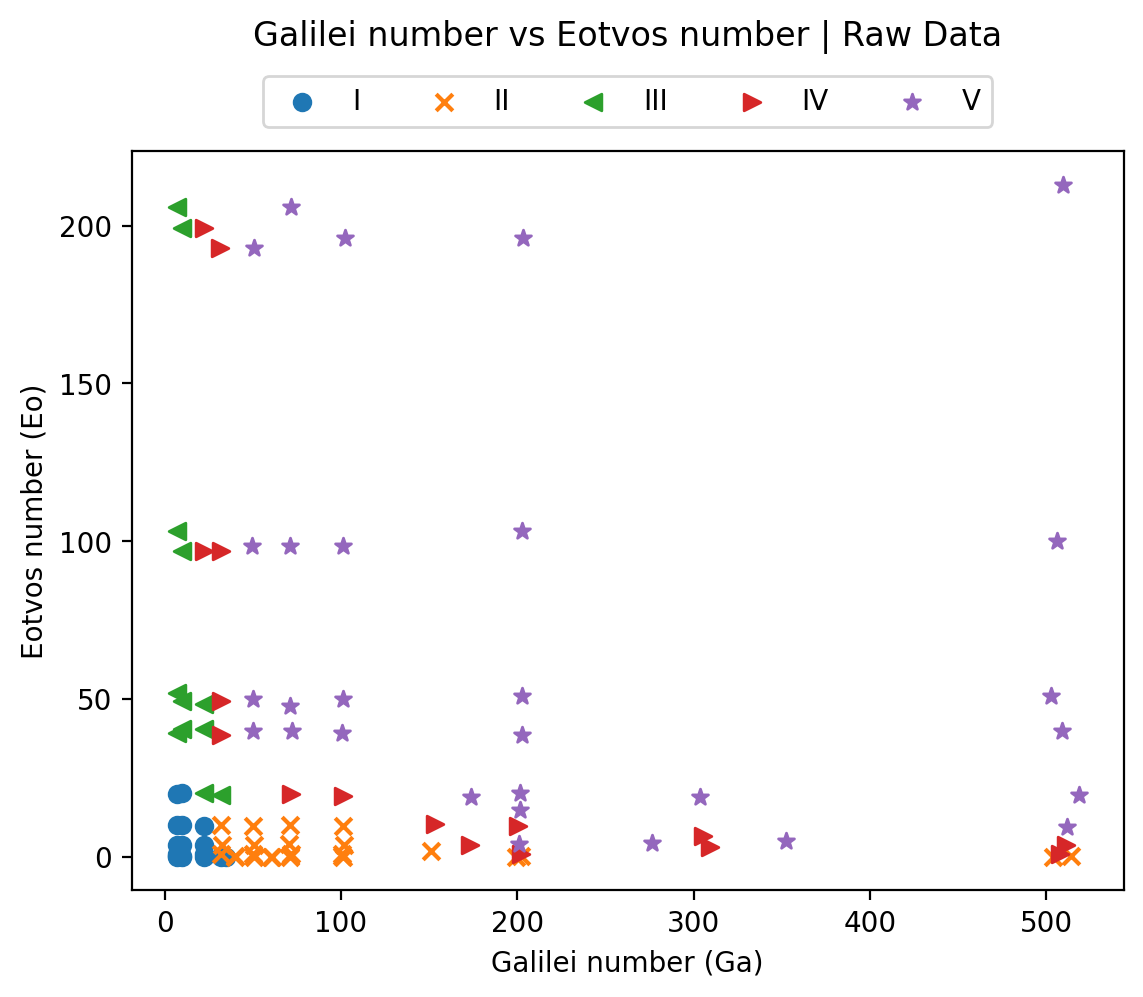

In [57]:
markers = ["o", "x", "<", ">", "*"]
for regime, marker in zip(regimes, markers):
  plt.scatter(data[data["regime"]==regime]["Ga"], data[data["regime"]==regime]["Eo"], marker=marker, label=regime)
plt.title("Galilei number vs Eotvos number | Raw Data", y=1.12)
plt.xlabel("Galilei number (Ga)")
plt.ylabel("Eotvos number (Eo)")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=5)
plt.savefig(f"{output_path}/00_raw_data_scatter.png", bbox_inches='tight')


Now we take the log of the Galilei and Eotvos numbers to better visualize the data. Then we normalize the data to be in the range of [-1, 1].

We will use the min-max-normalization formula:
$$
\text{ (1) } x_i^* = \frac{x_i - x_{\min}}{x_{\max} - x_{\min}},\ x_i^{*} \in [0, 1] 
$$

$$
\text{(2)}\quad \tilde{x}_i = 2x_i^* - 1,\quad \tilde{x}_i \in [-1,1]
$$


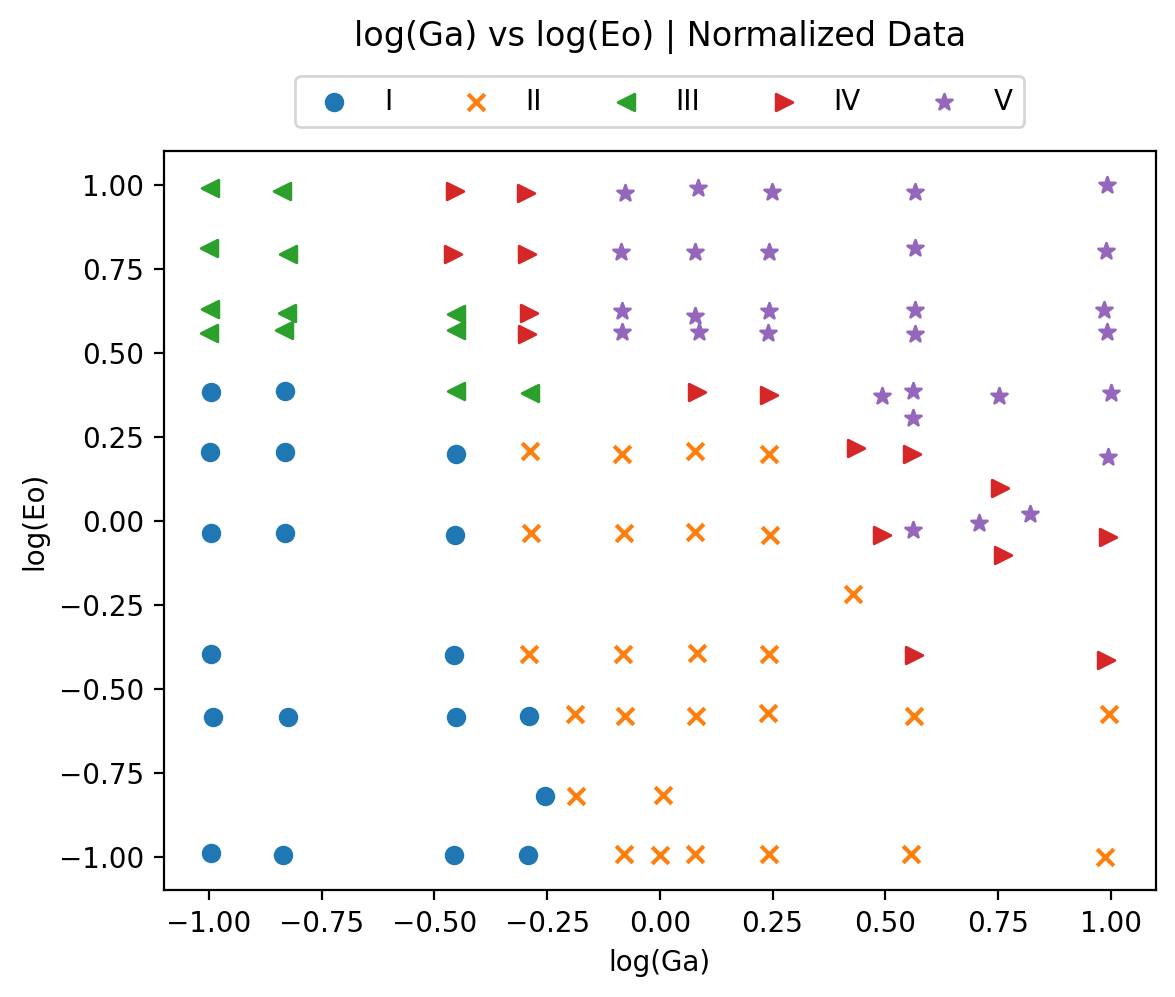

In [58]:
logData = data[["Ga", "Eo"]].apply(np.log10)
logData["regime"] = data["regime"].copy()
min_vals = logData[["Ga", "Eo"]].min()
max_vals = logData[["Ga", "Eo"]].max()
logData[["Ga", "Eo"]] = (logData[["Ga", "Eo"]] - min_vals)/(max_vals - min_vals)
logData[["Ga", "Eo"]] = 2 * logData[["Ga", "Eo"]] - 1

for regime, marker in zip(regimes, markers):
  plt.scatter(logData[logData["regime"]==regime]["Ga"], logData[logData["regime"]==regime]["Eo"], marker=marker, label=regime)
plt.title("log(Ga) vs log(Eo) | Normalized Data", y=1.12)
plt.xlabel("log(Ga)")
plt.ylabel("log(Eo)")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=5)
plt.savefig(f"{output_path}/01_normalized_data_scatter.png", bbox_inches='tight')

## Binary Classification with Perceptron

Task: create Model that can classify between regime I and II based on the features Ga and Eo.
Method: Perceptron algorithm.

- **features**
  - Galilei: $\tilde{Ga} = f(log_{10}(Ga)), \tilde{Ga} \in [-1, 1]$
  - Eötvös: $\tilde{Eo} = f(log_{10}(Eo)), \tilde{Eo} \in [-1, 1]$
  - Feature vector: $\underline{x} = (\tilde{Ga}, \tilde{Eo}, 1)^T$
- **labels**
  - Scalar label: $y = \begin{cases} 0 & \text{if \underline{x} in regime I} \\ 1 & \text{if \underline{x} in regime II} \end{cases}$
- **Perceptron model**
  - Weights: $\underline{w} = (w_1, w_2, b)^T$
  - Linear combination (linear function): $z = \underline{w}^T \underline{x} = w_1 \tilde{Ga} + w_2 \tilde{Eo} + b$
  - Activation function is Heaviside (Prediction): $\hat{y} = H(z) = \begin{cases} 0 & z < 0 \\ 1 & z \geq 0 \end{cases}$
- **Training the model**
  - Loss function: MSE (Mean Squared Error) $L = \frac{1}{2} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2$
  - Solving for weights using Gradient Descent:
    - Weight update rule: $\underline{w}^{n+1} = \underline{w}^n - \eta \frac{\partial L}{\partial \underline{w}}$
    - Learning rate: $\eta$
    - Gradient of the loss func*tion: $\frac{\partial L}{\partial \underline{w}} = - \sum_{i=1}^{N} (y_i - \hat{y}_i) \underline{x}_i$
    - End Equation for weight update: $\underline{w}^{n+1} = \underline{w}^n + \eta \sum_{i=1}^{N} (y_i - \hat{y}_i) \underline{x}_i = \begin{pmatrix} w_1^{(n)} \\ w_2^{(n)} \\ b^{(n)} \end{pmatrix}$ + $\eta \sum_{i=1}^{N} (y_i - \hat{y}_i) \begin{pmatrix} \tilde{Ga}_i \\ \tilde{Eo}_i \\ 1 \end{pmatrix}$


In [59]:
class Perceptron:
    """Implements perceptron algorithm and learning rule."""
    def __init__(self, n_weights: int):
        """Initialize perceptron instance.

        :param n_weights: number of free parameters; must be
            equal to the number of features
        :type n_weights: int
        """

        self._p = pt.rand(n_weights) * 2 - 1  # weights (w1,w2,b) initialized randomly in [-1, 1]

    def _loss(self, X: pt.Tensor, y: pt.Tensor) -> pt.Tensor:
        """Compute perceptron loss.

        :param y_hat: predicted labels
        :type y_hat: pt.Tensor
        :param y: target labels
        :type y: pt.Tensor
        :return: perceptron loss
        :rtype: pt.Tensor
        """
        y_hat = self.predict(X)
        return 0.5 * pt.sum((y - y_hat) ** 2)

    def _loss_gradient(self, X : pt.Tensor, y: pt.Tensor) -> pt.Tensor:
        y_hat = self.predict(X)
        delta = y - y_hat # (yi - y_hat_i)
        feature_vector = pt.cat((X, pt.ones(X.shape[0], 1)), dim=1) # x = (Ga, Eo, 1)^T
        return -(delta @ feature_vector)  # sum_i (yi - y_hat_i) * xi

    def predict(self, X: pt.Tensor) -> pt.Tensor:
        weights = self._p[:-1]  # w1, w2
        bias = self._p[-1] # b
        linear_output = X @ weights + bias  # w1*x1 + w2*x2 + b
        return pt.heaviside(linear_output, pt.tensor(0.0))

    def train(self, X: pt.Tensor, y: pt.Tensor, learning_rate=0.01, epochs=100, tol=1e-4):
        """Train perceptron using perceptron learning rule."""

        loss = []
        for epoch in range(epochs):
            self._p = self._p - learning_rate * self._loss_gradient(X, y)
            loss.append(self._loss(X, y).item())
            if loss[-1] < tol:
                print(f"Converged after epochs {epoch+1}")
                return loss
        print(f"Did not converge within {epochs} epochs")
        print(f"Final loss: {loss[-1]:.4f}")
        return loss

In [ ]:
reg_1_2 = (logData["regime"] == "I") | (logData["regime"] == "II") # Select regimes I and II
features = pt.tensor(logData[reg_1_2][["Ga", "Eo"]].values, dtype=pt.float32)
logData["label"] = 0
mapping = {regime: i for i, regime in enumerate(regimes)} # {'I': 0, 'II': 1, 'III': 2, 'IV': 3, 'V': 4}
logData["label"] = logData["regime"].map(mapping)
labels = pt.tensor(logData["label"][reg_1_2].values, dtype=pt.float32)

torch.Size([46])

In [61]:
perceptron_model = Perceptron(n_weights=3)  # 2 features + bias
loss = perceptron_model.train(features, labels)
p = perceptron_model._p
print(f"Final equations: z={p[0]:2.3f}Ga{p[1]:+2.3f}Eo{p[2]:+2.3f}")

Converged after epochs 30
Final equations: z=0.288Ga+0.059Eo+0.117


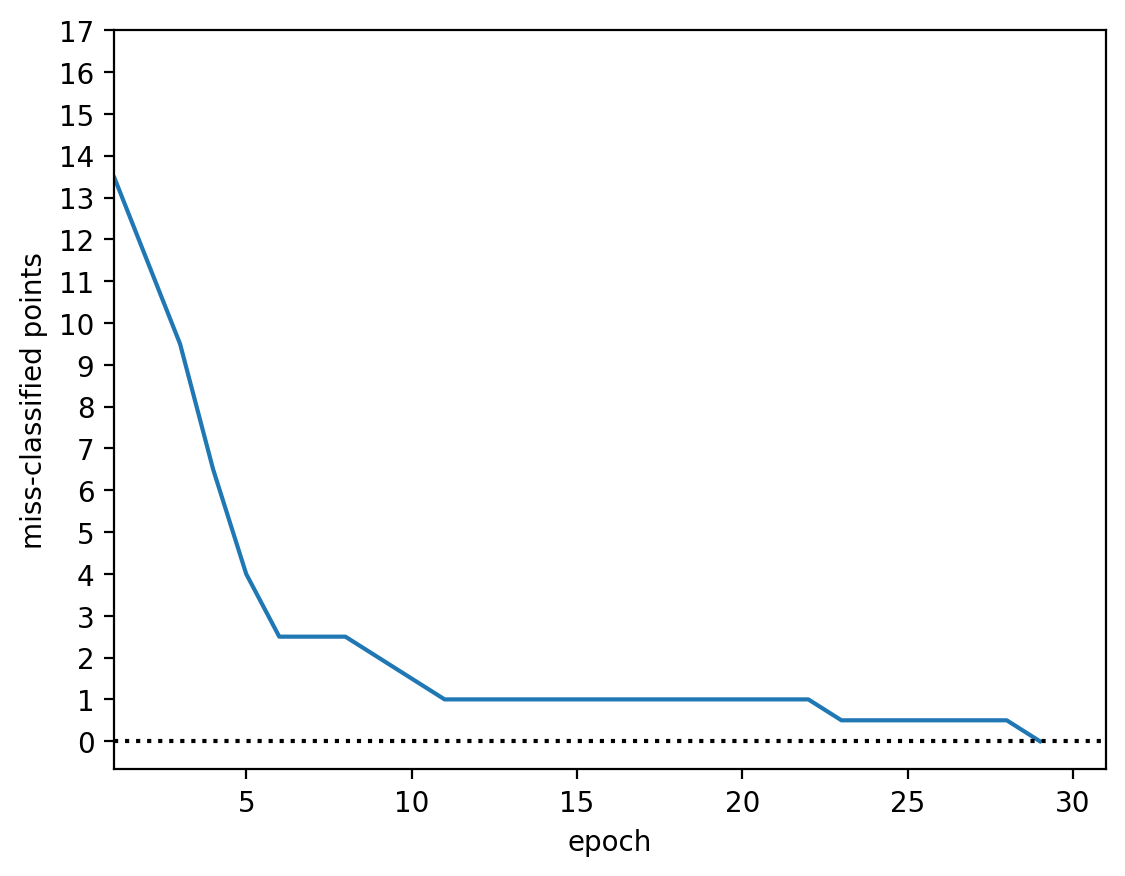

In [63]:
plt.plot(range(len(loss)), loss)
plt.xlabel("epoch")
plt.ylabel("miss-classified points")
plt.xlim(1.0, len(loss)+1)
plt.axhline(0.0, 0.0, 1.0, ls=":", c="k")
plt.yticks(pt.linspace(0.0, 17, 18))
plt.savefig(f"{output_path}/perceptron_loss.svg", bbox_inches="tight")